# Predict Future Sales | [Kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)


## Downloading the dataset from Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrhighsenberg","key":"062e96956df61b723a057902421dddf1"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 69.3MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.98MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 155MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.17MB/s]
 75% 10.0M/13.3M [00:00<00:00, 34.0MB/s]
100% 13.3M/13.3M [00:00<00:00, 30.0MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 111MB/s]


In [4]:
!unzip items.csv.zip -d data
!unzip sales_train.csv.zip -d data
!unzip sample_submission.csv.zip -d data
!unzip test.csv.zip -d data
!mv *.csv data

Archive:  items.csv.zip
  inflating: data/items.csv          
Archive:  sales_train.csv.zip
  inflating: data/sales_train.csv    
Archive:  sample_submission.csv.zip
  inflating: data/sample_submission.csv  
Archive:  test.csv.zip
  inflating: data/test.csv           


In [0]:
rm -rf *.zip

## Loading the data and libraries

In [0]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

import scipy.sparse 
from tqdm import tqdm_notebook
from itertools import product
import gc

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [0]:
path = 'data/'

# Training data
sales = pd.read_csv(path+'sales_train.csv')

# Testing data
test = pd.read_csv(path+'test.csv')

# Additional information
items = pd.read_csv(path+'items.csv')
item_cats = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')

In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## EDA 

In [10]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [14]:
sales.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

### Data Visualizations

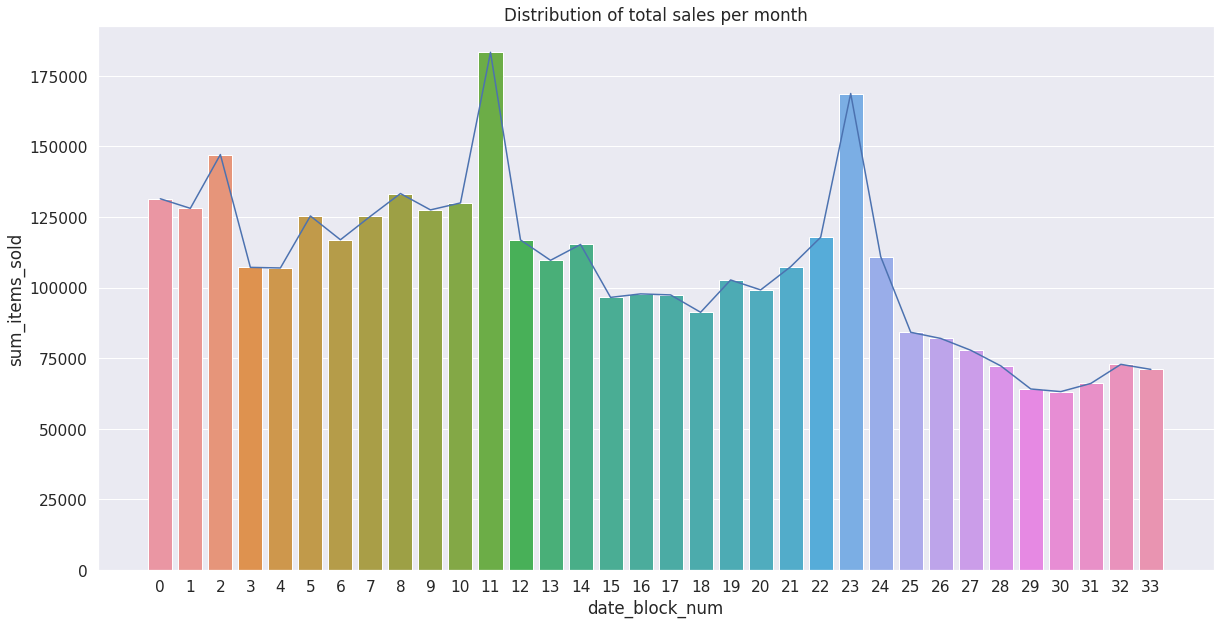

In [27]:
sns.set_context("notebook", font_scale=1.4)
sales_month = sales.groupby(['date_block_num']).sum().item_cnt_day.reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of total sales per month')
del sales_month

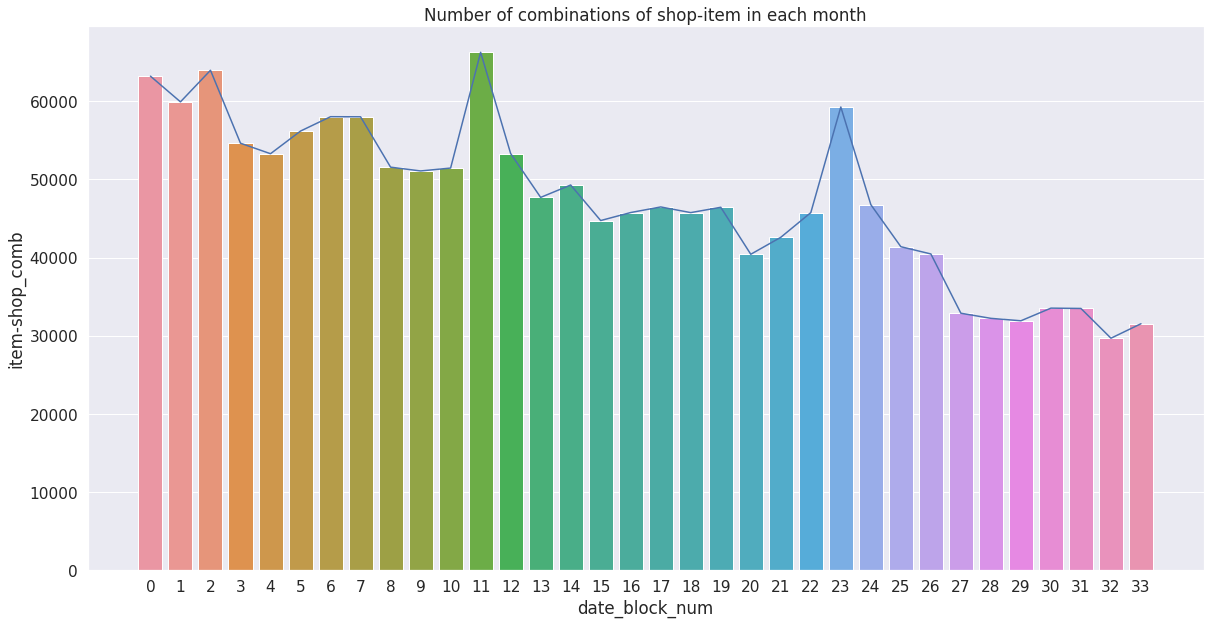

In [28]:
comb_shop_item = sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size().reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations of shop-item in each month')
del comb_shop_item


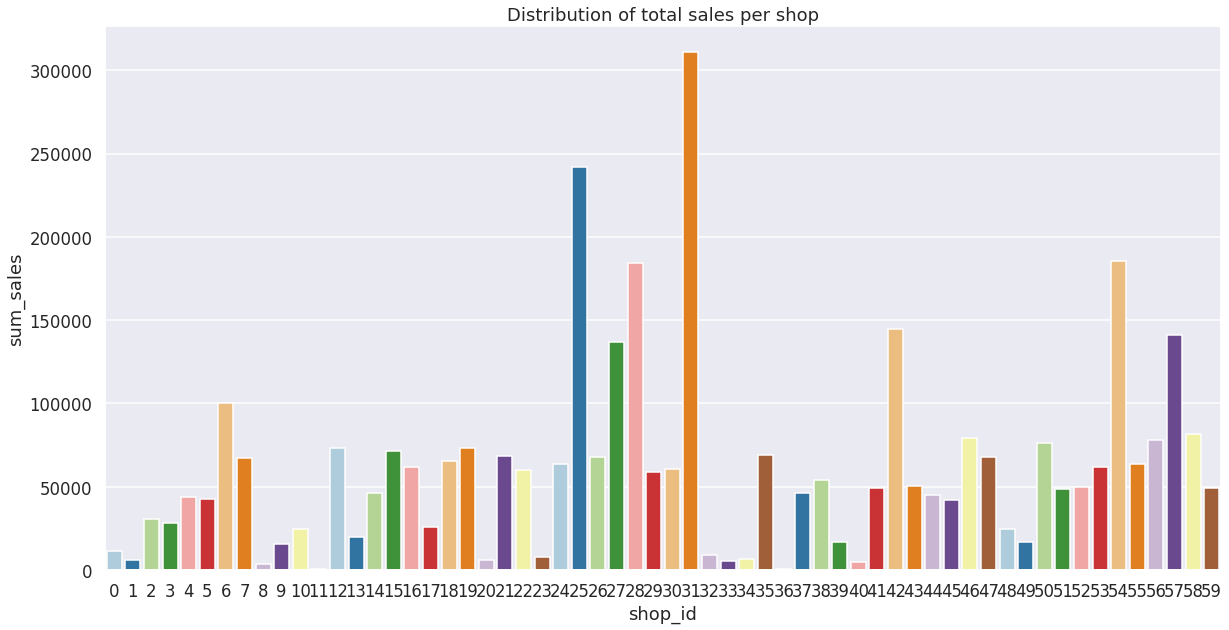

In [30]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of total sales per shop');
del sales_month_shop_id

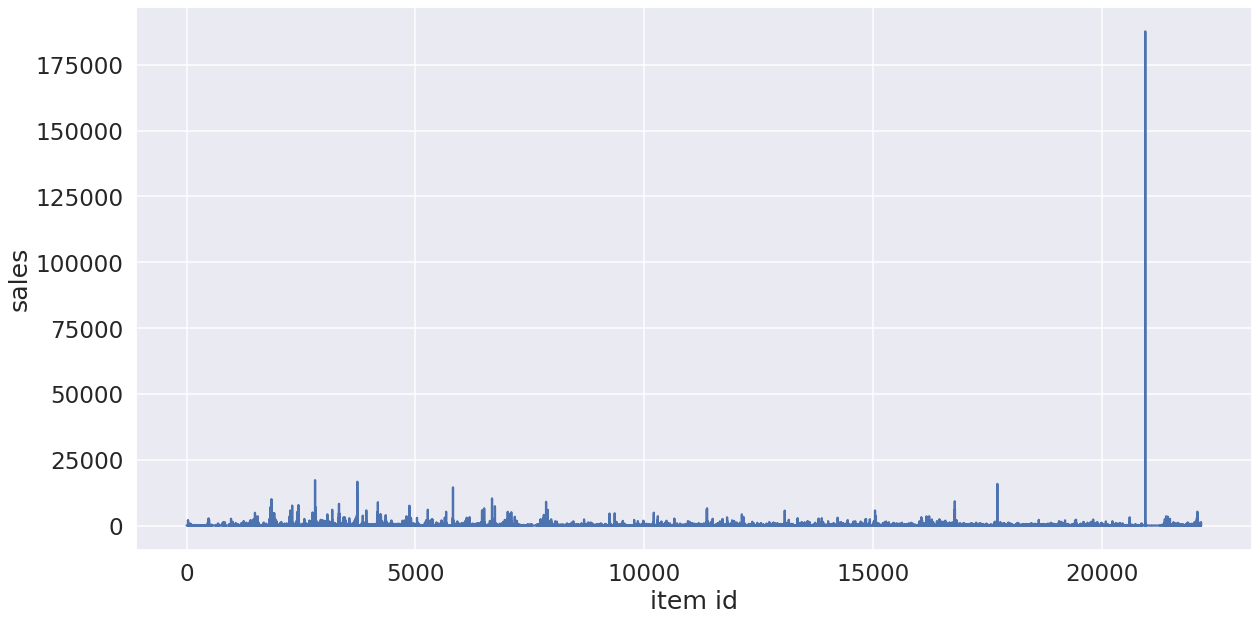

In [31]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

It is observed that there is one outlier whose sales are phenomenally higher than the others.

## Feature Engineering

#### Aggregation and Lagged Features

In [0]:
# Defining helper functions

# To save memory by downcasting to int32
def downcast_dtypes(df):
    
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# To compute features discussed in the course - aggregation, lagged features
def get_feature_matrix(train, test, items, list_lags, date_block_threshold):
  
    # Create "grid" with columns
    groupby_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in train['date_block_num'].unique():
        cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = groupby_cols,dtype=np.int32)
            
    # Add submission shop_id-item_id in order to test predictions
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    gb = train.groupby(by=groupby_cols, as_index=False).agg({'item_cnt_day': ['sum']})
    gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
    gb.rename(columns={'item_cnt_day_sum': 'target'}, inplace=True)
    all_data = pd.merge(grid, gb, how='left', on=groupby_cols).fillna(0)

    gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day': ['sum']})
    gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
    gb.rename(columns={'item_cnt_day_sum': 'target_item'}, inplace=True)
    all_data = pd.merge(all_data, gb, how='left', on=['date_block_num', 'item_id']).fillna(0)

    gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day': ['sum']})
    gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
    gb.rename(columns={'item_cnt_day_sum': 'target_shop'}, inplace=True)
    all_data = pd.merge(all_data, gb, how='left', on=['date_block_num', 'shop_id'])

    # # Groupby data to get shop-item-month aggregates
    # gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # # Fix column names
    # gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # # Join it to the grid
    # all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # # Same as above but with shop-month aggregates
    # gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    # gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    # all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # # Same as above but with item-month aggregates
    # gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    # gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    # all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(groupby_cols)) 

    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[groupby_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=groupby_cols, how='left').fillna(0)

    del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(groupby_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

In [51]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = sales[sales.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_for_modelling, test, items, list_lags, date_block_threshold)

### Mean Encodings

In [0]:
mean_enc_item_cat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id']
all_data = pd.merge(all_data, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
del mean_enc_item_cat
all_data = downcast_dtypes(all_data)

In [57]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_item,target_shop,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id
0,54,10297,12,4.0,23.0,3416.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281
1,54,10298,12,14.0,182.0,3416.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868
2,54,10300,12,3.0,26.0,3416.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281
3,54,10292,12,9.0,93.0,3416.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868
4,54,10143,12,1.0,12.0,3416.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726


### Validation Strategy

In [58]:
# Creating a placeholder dataframe for submission
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
sub_data.head()

,shop_id,item_id,date_block_num,target,target_item,target_shop,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659


In [0]:
# Using 33rd month as validation
dates = all_data['date_block_num']
boolean_test = (dates.isin([33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [60]:
print('X_train shape is ' + str(X_train.shape))
print('X_val shape is ' + str(X_val.shape))

X_train shape is (2902146, 13)
X_val shape is (208428, 13)


# Modelling

In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)
def rmse(*args):
    return np.sqrt(mean_squared_error(*args))

### LightGBM

In [76]:
learning_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
best_rmse = 9999999999999
for lr in tqdm_notebook(learning_rates):
    print("LR:", lr)
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=clip40(y_train)), int(100 * (lr / 0.03)))
    pred_lgb_val = lgb_model.predict(X_val)
    score = rmse(clip20(y_val), clip20(pred_lgb_val))

    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        best_lgb = lgb_model

LR: 0.01
LR: 0.03
LR: 0.05
LR: 0.07
LR: 0.09
LR: 0.1



In [66]:
print("Best learning rate is" + str(best_lr))

Best learning rate is0.02


Training whole dataset with best LR

In [0]:
X = X_train.append(X_val)
y = np.append(y_train, y_val)

best_lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': best_lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
best_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=clip40(y)), int(100 * (lr / 0.03)))

In [0]:
filename = 'best_lgb.sav'
pickle.dump(best_lgb, open(filename, 'wb'))

### Random Forest

In [0]:
import xgboost as xgb

In [0]:
# Using 33rd month as validation
dates = all_data['date_block_num']
boolean_test = (dates.isin([33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [0]:
Train = xgb.DMatrix(X_train, y_train)
Val = xgb.DMatrix(X_val, y_val)

In [0]:
X = X_train.append(X_val)
Y = np.concatenate([y_train, y_val])

In [0]:
best_rmse = 9999999999999

for max_features in tqdm_notebook([4,6,8]):
  for max_depth in [8,10,12]:
    rf = RandomForestRegressor(n_estimators=100, n_jobs=4, max_features=max_features, max_depth=max_depth,verbose=5)
    rf.fit(X,Y)

    pred_rf_val = rf.predict(X_val)
    score = rmse(clip20(y_val), clip20(pred_rf_val))

    if score<best_rmse:
      best_rmse = score
      print("------Current best_rmse: ",best_rmse," ---------")
      best_rf = rf
      best_max_features = max_features
      best_max_depth = max_depth


In [122]:
print("Best Rmse is ",best_rmse)
print("Best max_features is ",best_max_features)
print("Best max_depth is ",best_max_depth)

Best Rmse is  0.9556476216505307
Best max_features is  8
Best Rmse is  12


### Fitting best RF on whole dataset

In [0]:
X = X_train.append(X_val)
y = np.append(y_train, y_val)

best_rf_model = RandomForestRegressor(n_estimators=100, n_jobs=4, max_features=best_max_features, max_depth=best_max_depth,verbose=5)
best_rf_model.fit(X,clip40(y))

In [0]:
filename = 'best_rf_model.sav'
pickle.dump(best_rf_model, open(filename, 'wb'))

## Stacking

In [125]:
pred_lgb_val = clip20(best_lgb.predict(X_val))
pred_rf_val = clip20(best_rf_model.predict(X_val.fillna(0)))
X_val_level2 = np.c_[pred_rf_val, pred_lgb_val]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


### Using LR for stacking on level2 predictions

In [127]:
lr = LinearRegression()
lr.fit(X_val_level2, clip40(y_val))
pred_lr_val =  clip20(lr.predict(X_val_level2))
print('Rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

Rmse for stacking variables is 0.822126


## Submission

In [129]:
pred_test_rf = best_rf_model.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
pred_test_lgb = best_lgb.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
X_test_level2 = np.c_[pred_test_rf, pred_test_lgb]
test_pred = clip20(lr.predict(X_test_level2))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [0]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('submission.csv',index=False)

In [132]:
submision.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.400325
1,1,5,5320,0.868182
2,2,5,5233,1.100133
3,3,5,5232,0.379577
4,4,5,5268,1.493976
